In [2]:
using CancerSeqSim
using DataFrames
using RCall
using ProgressMeter
using Distributions
using Random
R"""
library(viridis)
library(cowplot)
library(tidyverse)
library(popgendnds) #this is a package written for the project that does a ML fit
""";

## Summary

In this notebook, I'll generate a synthetic cohort of tumours and then apply the theoretical model of $dN/dS$ to extract the input parameters. I'll also consider the impact of high mutation rates and use the simulation to calculate the power of the inference in terms of the number of mutations

### Generate synthetic cohort

In [7]:
Random.seed!(123)
mup = 0.1
Nmax = 10^5
mud = mup/(Nmax)
mud = 0.005
println(Nmax * mud)
its = 500
svec = [0.0, 0.25, 0.5, -0.1]
Nd = zeros(Float64, its * length(svec))
Np = zeros(Float64, its * length(svec))
clonesized = zeros(Float64, its * length(svec))
clonesizep = zeros(Float64, its * length(svec))
sel = String[]
j = 1

driverVAF = Float64[]
passengerVAF = Float64[]
simnumdriver = Int64[]
simnumpass = Int64[]
seld = Float64[]
selp = Float64[]

for s in svec
    println(s)
    sfunc() = s
    @showprogress for i in 1:its
        x = simulatedifferentmutations(Nmax = Nmax, μp = mup, μd = mud, clonalmutations = 100, s = sfunc,
        fitnessfunc = CancerSeqSim.nonmultiplicativefitness);
        append!(driverVAF, 
            map((depth, freq) -> rand(Binomial(depth, freq))/depth, rand(Poisson(100), length(x.output.trueVAFd)), 
            x.output.trueVAFd./Nmax))
        append!(passengerVAF, 
            map((depth, freq) -> rand(Binomial(depth, freq))/depth, rand(Poisson(100), length(x.output.trueVAFp)), 
            x.output.trueVAFp./Nmax))
        #append!(driverVAF, x.output.trueVAFd./Nmax)
        #append!(passengerVAF, x.output.trueVAFp./Nmax)
        append!(simnumdriver, fill(i, length(x.output.trueVAFd)))
        append!(simnumpass, fill(i, length(x.output.trueVAFp)))
        append!(seld, fill(s, length(x.output.trueVAFd)))
        append!(selp, fill(s, length(x.output.trueVAFp)))
    end
end

DFd = DataFrame(VAF = driverVAF, s = seld, simnum = simnumdriver)
DFp = DataFrame(VAF = passengerVAF, s = selp, simnum = simnumpass)

dfd = DFd[DFd[:VAF] .> 0.01, :]
dfp = DFp[DFp[:VAF] .> 0.01, :]

#writetable("simulation-data/drivers.csv", dfd)
#writetable("simulation-data/passengers.csv", dfp)


@rput dfp
@rput dfd

500.0
0.0


Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:01

0.25


Progress: 100%|█████████████████████████████████████████| Time: 0:04:16
Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:00

0.5


Progress: 100%|█████████████████████████████████████████| Time: 0:03:48
Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:00

-0.1


Progress: 100%|█████████████████████████████████████████| Time: 0:04:05
Progress: 100%|█████████████████████████████████████████| Time: 0:03:32


,VAF,s,simnum
,Float64,Float64,Int64
1,0.0188679,0.0,1
2,0.0102041,0.0,1
3,0.0106383,0.0,1
4,0.0322581,0.0,2
5,0.0103093,0.0,2
6,0.0108696,0.0,2
7,0.0183486,0.0,3
8,0.0105263,0.0,3
9,0.0104167,0.0,3


In [16]:
# we'll move over to R to fit the data and make the plot using popgendnds
# dN/dS calcuations are weighted 
R"""

#dfd <- read.csv("simulation-data/drivers.csv")
#dfp <- read.csv("simulation-data/passengers.csv")

dnds <- data.frame()
for (selection in unique(dfd$s)){
    drivers <- dfd %>%
    filter(s == selection)
    passengers <- dfp %>%
    filter(s == selection)

out <- get_cumulative(drivers$VAF, passengers$VAF, ccfmin = 0.01, mud = 0.005, mup = 0.1, step = 0.025) %>%
    mutate(w = nmuts/max(nmuts)) %>%
    filter(VAF < 0.5) %>%
    select(VAF, dnds, w) %>%
    fitintervaldNdSlsq(., trues = selection, ccfmin = 0.01)
    print(out)
    dnds <- rbind(dnds, out$data)
}

write_csv(dnds, "FinalFigures/data_for_figures/cancer_simulation_dnds.csv")
   
"""

[1] 6.791279 1.536431
[1] "adding fake CI intervals"
Estimated s = -0.027
Estimated A (95% CI) = 0.878
True s =  0 
Estimated N =  NaN 

[1] 13.3393730  0.9934467
[1] "adding fake CI intervals"
Estimated s = 0.188
Estimated A (95% CI) = 3.891
True s =  0.25 
Estimated N =  2.685387e-05 

[1] 21.6930209  0.9057549
[1] "adding fake CI intervals"
Estimated s = 0.39
Estimated A (95% CI) = 9.27
True s =  0.5 
Estimated N =  0.03514173 

[1] 5.008985 1.882645
[1] "adding fake CI intervals"
Estimated s = -0.085
Estimated A (95% CI) = 0.47
True s =  -0.1 
Estimated N =  NaN 



┌ Warning: RCall.jl: Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
└ @ RCall /Users/marcwilliams/.julia/packages/RCall/RPlFw/src/io.jl:110


RObject{VecSxp}
     CCF      dnds         w         A        sfit    dndsth trues     cilow
1  0.035 1.0143934 0.9089480 0.8783057 -0.02708699 1.0121433  0.00 1.0143934
2  0.060 1.0063966 0.9524116 0.8783057 -0.02708699 1.0081708  0.00 1.0063966
3  0.085 1.0076413 0.9674151 0.8783057 -0.02708699 1.0061540  0.00 1.0076413
4  0.110 1.0036061 0.9759738 0.8783057 -0.02708699 1.0049017  0.00 1.0036061
5  0.135 1.0033648 0.9815937 0.8783057 -0.02708699 1.0040369  0.00 1.0033648
6  0.160 1.0017034 0.9853059 0.8783057 -0.02708699 1.0033986  0.00 1.0017034
7  0.185 1.0002192 0.9877807 0.8783057 -0.02708699 1.0029052  0.00 1.0002192
8  0.210 1.0012858 0.9894821 0.8783057 -0.02708699 1.0025109  0.00 1.0012858
9  0.235 1.0014205 0.9909773 0.8783057 -0.02708699 1.0021876  0.00 1.0014205
10 0.260 1.0025377 0.9920858 0.8783057 -0.02708699 1.0019170  0.00 1.0025377
11 0.285 1.0027536 0.9929623 0.8783057 -0.02708699 1.0016868  0.00 1.0027536
12 0.310 1.0023424 0.9938903 0.8783057 -0.02708699 1.0014883

┌ Warning: RCall.jl: Scale for 'fill' is already present. Adding another scale for 'fill', which
│ will replace the existing scale.
└ @ RCall /Users/marcwilliams/.julia/packages/RCall/RPlFw/src/io.jl:110


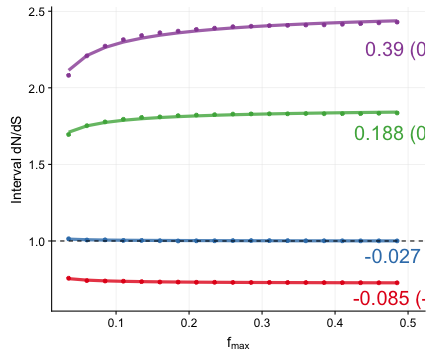

RObject{VecSxp}


In [17]:
R"""
labels <- dnds %>%
mutate(trues = paste0(trues)) %>%
group_by(trues, sfit) %>%
#distinct(trues, sfit, sfitmin, sfitmax) %>%
summarize(y = 1.0*mean(dnds) -0.1 ) %>%
mutate(x = 0.5) %>%
mutate(label = paste0(round(sfit,3), " (", trues,")"))

gsim <- dnds %>%
mutate(trues = paste0(trues)) %>%
ggplot2::ggplot(ggplot2::aes(x = CCF, y = dnds, fill = trues, group = trues)) +
ggplot2::geom_point(aes(col = trues)) +
    ggplot2::geom_line(ggplot2::aes(y = dndsth, col = trues),  size = 1.5, alpha = 0.8) +
    #ggplot2::geom_ribbon(ggplot2::aes(ymin = dndsthmin, ymax = dndsthmax, fill = trues), alpha = 0.2) +
    ggplot2::ylab("Interval \n dN/dS") + ggplot2::xlab(expression(f[max])) +
    geom_hline(yintercept = 1.0, lty = 2) +
    xlab(expression(f[max])) +
    ylab("Interval dN/dS") +
    scale_fill_hue(l=40) +
    background_grid(major = "xy", minor = "none") +
#scale_color_viridis(option="plasma", discrete = T) + scale_fill_viridis(option="plasma", discrete = T) +
    scale_fill_brewer(palette="Set1") +
scale_colour_brewer(palette="Set1") +
geom_text(data = labels, aes(x = x, y = y, label = label, col = trues), size = 7) + 
theme(legend.position="none")
gsim
"""

### Generate synthetic cohort with different mutation rates

In [18]:
using Random
Random.seed!(123)
mup = 0.5
Nmax =  10^4
mudvec = [0.2, 0.1, 0.01, 0.005, 0.001]
println(Nmax.*mudvec)
its = 1000
Nd = zeros(Float64, its * length(mudvec))
Np = zeros(Float64, its * length(mudvec))
clonesized = zeros(Float64, its * length(mudvec))
clonesizep = zeros(Float64, its * length(mudvec))
sel = String[]
j = 1

driverVAF = Float64[]
passengerVAF = Float64[]
simnumdriver = Int64[]
simnumpass = Int64[]
mudout = Float64[]
mupout = Float64[]
soutd = Float64[]
soutp = Float64[]
svec = [0.0, 0.2, 0.5]

for sel in svec
    println(sel)
    sfunc() = sel
    println(sfunc())
    for mud in mudvec
        println(mud)
        @showprogress for i in 1:its
            x = simulatedifferentmutations(Nmax = Nmax, μp = mup, μd = mud, clonalmutations = 0, s = sfunc,
            fitnessfunc = CancerSeqSim.nonmultiplicativefitness);
            append!(driverVAF, x.output.trueVAFd./Nmax)
            append!(passengerVAF, x.output.trueVAFp./Nmax)
            append!(simnumdriver, fill(i, length(x.output.trueVAFd)))
            append!(simnumpass, fill(i, length(x.output.trueVAFp)))
            append!(mudout, fill(mud, length(x.output.trueVAFd)))
            append!(mupout, fill(mud, length(x.output.trueVAFp)))
            append!(soutp, fill(sel, length(x.output.trueVAFp)))
            append!(soutd, fill(sel, length(x.output.trueVAFd)))
        end
    end
end

DFd = DataFrame(VAF = driverVAF, mud = mudout, trues = soutd, simnum = simnumdriver)
DFp = DataFrame(VAF = passengerVAF, mud = mupout, trues = soutp, simnum = simnumpass)

dfd = DFd[DFd[:VAF] .> 0.01, :]
dfp = DFp[DFp[:VAF] .> 0.01, :]

@rput dfp
@rput dfd

[2000.0, 1000.0, 100.0, 50.0, 10.0]
0.0
0.0
0.2


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

0.1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

0.01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

0.005


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

0.001


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

0.2
0.2
0.2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
Progress: 100%|████████████████████████████████████████▊|  ETA: 0:00:00

0.1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:33
Progress: 100%|████████████████████████████████████████▊|  ETA: 0:00:00

0.01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:29
Progress: 100%|████████████████████████████████████████▊|  ETA: 0:00:00

0.005


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25
Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

0.001


Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

0.5
0.5
0.2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:00

0.1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43
Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

0.01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

0.005


Progress: 100%|█████████████████████████████████████████| Time: 0:00:30
Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

0.001


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


,VAF,mud,trues,simnum
,Float64,Float64,Float64,Int64
1,0.698,0.2,0.0,1
2,0.0294,0.2,0.0,1
3,0.1778,0.2,0.0,1
4,0.0764,0.2,0.0,1
5,0.0358,0.2,0.0,1
6,0.0329,0.2,0.0,1
7,0.1449,0.2,0.0,1
8,0.0183,0.2,0.0,1
9,0.0161,0.2,0.0,1


In [19]:
# we'll move over to R to fit the data and make the plot using popgendnds
R"""
ccfmin <- 0.01
dnds <- data.frame()
for (sel in rev(unique(dfp$trues))){
print(paste0("selection = ", sel))
    for (mu in unique(dfp$mud)){
        print(mu)
        drivers <- dfd %>%
            filter(VAF > ccfmin) %>%
            filter(mud == mu, trues == sel)
        passengers <- dfp %>%
            filter(VAF > ccfmin) %>%
            filter(mud == mu, trues == sel)

        cum1 <- get_cumulative(drivers$VAF, passengers$VAF, 
                ccfmin = ccfmin, mud = mu, mup = 0.5, step = 0.01) %>%
                mutate(w = nmuts/max(nmuts)) %>%
                select(VAF, dnds, w)
        out <- cum1 %>%
            fitintervaldNdSlsq(., trues = sel, ccfmin = ccfmin)
        print(out)
        dnds <- rbind(dnds, mutate(out$data, mud = mu))
    }
} 

write_csv(dnds, "FinalFigures/data_for_figures/cancer_simulation_diffmu_dnds.csv")
"""

[1] "selection = 0.5"
[1] 0.2
[1] 4.5965497 0.7935102
[1] "adding fake CI intervals"
Estimated s = 0.06
Estimated A (95% CI) = 1.372
True s =  0.5 
Estimated N =  1.54728e-22 

[1] 0.1
[1] 2.8835990 0.4442502
[1] "adding fake CI intervals"
Estimated s = 0.065
Estimated A (95% CI) = 1.553
True s =  0.5 
Estimated N =  2.39923e-20 

[1] 0.01
[1] 13.0232382  0.4702082
[1] "adding fake CI intervals"
Estimated s = 0.519
Estimated A (95% CI) = 12.861
True s =  0.5 
Estimated N =  0.1462447 

[1] 0.005
[1] 13.0168531  0.3686716
[1] "adding fake CI intervals"
Estimated s = 0.538
Estimated A (95% CI) = 16.773
True s =  0.5 
Estimated N =  0.1697415 

[1] 0.001
[1] 15.1622934  0.3291999
[1] "adding fake CI intervals"
Estimated s = 0.631
Estimated A (95% CI) = 24.322
True s =  0.5 
Estimated N =  0.3036647 

[1] "selection = 0.2"
[1] 0.2
[1] 3.8110634 0.7040612
[1] "adding fake CI intervals"
Estimated s = 0.035
Estimated A (95% CI) = 1.226
True s =  0.2 
Estimated N =  8.285688e-44 

[1] 0.1
[1] 

┌ Warning: RCall.jl: Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
└ @ RCall /Users/marcwilliams/.julia/packages/RCall/RPlFw/src/io.jl:110


RObject{VecSxp}
      CCF      dnds         w         A          sfit    dndsth trues     cilow
1    0.02 1.0323428 0.4954389  1.372027  0.0595239656 1.0171981   0.5 1.0323428
2    0.03 1.0310380 0.6626737  1.372027  0.0595239656 1.0255418   0.5 1.0310380
3    0.04 1.0300520 0.7471701  1.372027  0.0595239656 1.0306621   0.5 1.0300520
4    0.05 1.0345466 0.7984378  1.372027  0.0595239656 1.0342004   0.5 1.0345466
5    0.06 1.0349195 0.8327580  1.372027  0.0595239656 1.0368249   0.5 1.0349195
6    0.07 1.0381946 0.8571337  1.372027  0.0595239656 1.0388660   0.5 1.0381946
7    0.08 1.0390165 0.8747617  1.372027  0.0595239656 1.0405084   0.5 1.0390165
8    0.09 1.0394933 0.8888385  1.372027  0.0595239656 1.0418644   0.5 1.0394933
9    0.10 1.0412880 0.9003636  1.372027  0.0595239656 1.0430068   0.5 1.0412880
10   0.11 1.0421128 0.9098828  1.372027  0.0595239656 1.0439849   0.5 1.0421128
11   0.12 1.0418742 0.9175237  1.372027  0.0595239656 1.0448336   0.5 1.0418742
12   0.13 1.0426874 0.92

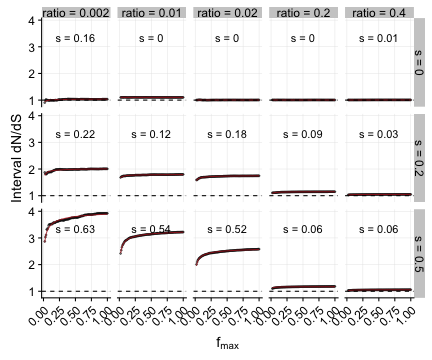

RObject{VecSxp}


In [20]:
R"""
labels <- dnds %>%
mutate(trues = paste0("s = ", trues), mud = paste0("ratio = ", mud/0.5)) %>%
group_by(mud, trues) %>%
summarize(s = paste0("s = ", round(first(sfit),2)), A = first(A))

g <- dnds %>%
#mutate(trues == factor(mud)) %>%
mutate(trues = paste0("s = ", trues), mud = paste0("ratio = ", mud/0.5)) %>%
ggplot2::ggplot(ggplot2::aes(x = CCF, y = dnds)) +
ggplot2::geom_point(col = "grey4", alpha = 0.5, size = 0.5) +
ggplot2::geom_line(ggplot2::aes(y = dndsth), col = "firebrick",  size = 0.5, alpha = 0.8) +
#ggplot2::geom_ribbon(ggplot2::aes(ymin = dndsthmin, ymax = dndsthmax), fill = "firebrick", alpha = 0.2) +
    ggplot2::ylab("Interval \n dN/dS") + ggplot2::xlab(expression(f[max])) +
    geom_hline(yintercept = 1.0, lty = 2) +
    xlab(expression(f[max])) +
    ylab("Interval dN/dS") +
    background_grid(major = "xy", minor = "none") +
    scale_color_viridis(option="plasma") + scale_fill_viridis(option="plasma") +

#geom_dl(aes(label = sfit), cex = 0.8) +
geom_text(data = labels, aes(x = 0.5, y = Inf, label = s),   
vjust  = 3) +
facet_grid(trues~mud) +
#ylim(c(0.6, 6)) +
theme(axis.text.x = element_text(angle = 45, hjust = 1))
save_plot("plots/4.Cancer-Theory/selection_mutation.pdf", g, base_height = 7, base_width = 8)

g
"""

### Power calculations

In these next set of simulations I'll look at how the number of mutations effects the inferences, this is particularly relevent for the case when we examine dn/ds at the level of individual genes. In this case the passenger and driver mutation rates are low so we'll set the baseline synonymous rate to 0.005, and the non-synonymous rate to 2.7X this (there are roughly 2.7X more non-synonymous sites than synonymous sites across the genome). We can then subsample from the cohort and look at how our inferences change as we change the number of mutations we sample.

In [32]:
Random.seed!(123)
mup = 0.005
Nmax =  10^5
mudvec = [2.7 * 0.005]
#mudvec = [0.005]
println(Nmax.*mudvec)
its = 2000
Nd = zeros(Float64, its * length(mudvec))
Np = zeros(Float64, its * length(mudvec))
clonesized = zeros(Float64, its * length(mudvec))
clonesizep = zeros(Float64, its * length(mudvec))
sel = String[]
j = 1

driverVAF = Float64[]
passengerVAF = Float64[]
simnumdriver = Int64[]
simnumpass = Int64[]
mudout = Float64[]
mupout = Float64[]
soutd = Float64[]
soutp = Float64[]
svec = [0.25]

for sel in svec
    println(sel)
    sfunc() = sel
    for mud in mudvec
        println(mud)
        @showprogress for i in 1:its
            x = simulatedifferentmutations(Nmax = Nmax, μp = mup, μd = mud, clonalmutations = 0, s = sfunc,
            fitnessfunc = CancerSeqSim.nonmultiplicativefitness);
            append!(driverVAF, x.output.trueVAFd./Nmax)
            append!(passengerVAF, x.output.trueVAFp./Nmax)
            append!(simnumdriver, fill(i, length(x.output.trueVAFd)))
            append!(simnumpass, fill(i, length(x.output.trueVAFp)))
            append!(mudout, fill(mud, length(x.output.trueVAFd)))
            append!(mupout, fill(mud, length(x.output.trueVAFp)))
            append!(soutp, fill(sel, length(x.output.trueVAFp)))
            append!(soutd, fill(sel, length(x.output.trueVAFd)))
        end
    end
end

DFd = DataFrame(VAF = driverVAF, mud = mudout, trues = soutd, simnum = simnumdriver)
DFp = DataFrame(VAF = passengerVAF, mud = mupout, trues = soutp, simnum = simnumpass)

dfd = DFd[DFd[:VAF] .> 0.01, :]
dfp = DFp[DFp[:VAF] .> 0.01, :]

@rput dfp
@rput dfd

[1350.0]
0.25
0.013500000000000002


Progress: 100%|█████████████████████████████████████████| Time: 0:11:58


,VAF,mud,trues,simnum
,Float64,Float64,Float64,Int64
1,0.02283,0.0135,0.25,1
2,0.02798,0.0135,0.25,1
3,0.05639,0.0135,0.25,1
4,0.03168,0.0135,0.25,1
5,0.01201,0.0135,0.25,1
6,0.01172,0.0135,0.25,1
7,0.01078,0.0135,0.25,1
8,0.85631,0.0135,0.25,2
9,0.10025,0.0135,0.25,2


In [29]:
# we'll move over to R to fit the data and make the plot using popgendnds
R"""

dnds <- data.frame()
j <- 1

samplevec <- c(10, 20, 30, 50, 75, 100, 200, 300, 500, 750, 1000) / length(dfp$VAF)

plots <- list()
i <- 1

for (samplefrac in samplevec){
    for (j in 1:30){
        print(samplefrac)
            drivers <- dfd %>%
        sample_frac(samplefrac)
            passengers <- dfp %>%
        sample_frac(samplefrac)
        print(length(drivers$VAF))
        print(length(passengers$VAF))
        ndrivers = length(drivers$VAF)
        npassengers = length(passengers$VAF)
        out <- get_cumulative(drivers$VAF, passengers$VAF, 
        ccfmin = 0.01, mud = mud, mup = mup, step = 0.01) %>%
                mutate(w = nmuts/max(nmuts)) %>%
                select(VAF, dnds, w) %>%
                fitintervaldNdSlsq(., trues = 0.25, ccfmin = 0.01)
                print(out)
        dnds <- rbind(dnds, mutate(out$data, sample = samplefrac, simnum = j, 
                    ndrivers = ndrivers, npassengers = npassengers))
        j <- j + 1
    }
plots[[i]] <- out$plot
i <- i + 1
} 
"""

[1] 0.00487567
[1] 62
[1] 10
[1] 3.1175830 0.3148284
[1] "adding fake CI intervals"
Estimated s = -0.025
Estimated A (95% CI) = 2
True s =  0.25 
Estimated N =  NaN 

[1] 0.00487567
[1] 62
[1] 10
[1] 0.005263529 0.026433444
[1] "adding fake CI intervals"
Estimated s = -0.548
Estimated A (95% CI) = 0.009
True s =  0.25 
Estimated N =  NaN 

[1] 0.00487567
[1] 62
[1] 10
[1] 3.8312224 0.3578162
[1] "adding fake CI intervals"
Estimated s = 0.005
Estimated A (95% CI) = 2.292
True s =  0.25 
Estimated N =  0 

[1] 0.00487567
[1] 62
[1] 10
[1] 27.9295665  0.7858103
[1] "adding fake CI intervals"
Estimated s = 1.106
Estimated A (95% CI) = 29.412
True s =  0.25 
Estimated N =  1.212369 

[1] 0.00487567
[1] 62
[1] 10
[1] 0.02402765 0.06571127
[1] "adding fake CI intervals"
Estimated s = -0.51
Estimated A (95% CI) = 0.019
True s =  0.25 
Estimated N =  NaN 

[1] 0.00487567
[1] 62
[1] 10
[1] 0.4896298 0.1845623
[1] "adding fake CI intervals"
Estimated s = -0.312
Estimated A (95% CI) = 0.271
True s

┌ Warning: RCall.jl: Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with

[1] 8.1624593 0.4371341
[1] "adding fake CI intervals"
Estimated s = 0.276
Estimated A (95% CI) = 6.296
True s =  0.25 
Estimated N =  0.002644508 



RObject{NilSxp}
NULL


[1] 6181


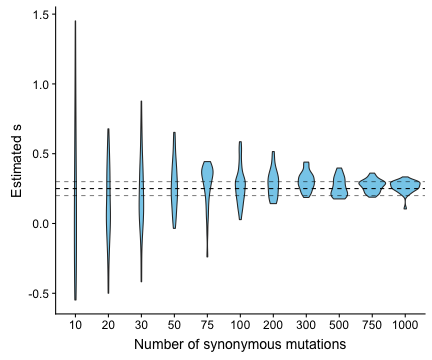

RObject{VecSxp}


In [31]:
R"""
write_csv(dnds, "FinalFigures/data_for_figures/cancer_simulation_power_dnds.csv")

library(forcats)
dfplot <- dnds %>%
    group_by(simnum, sample) %>%
    summarize(sfit = first(sfit), 
    #sfitmin = first(sfitmin), sfitmax = first(sfitmax), 
    trues = first(trues), 
    ndrivers = first(ndrivers), 
    npassengers = first(npassengers)) %>%
    mutate(driverspersample = ndrivers / 1000, passengerspersample = npassengers/1000) %>%
    ungroup()

print(mean(ndrivers))

gviolin <- dfplot %>%
    mutate(sample = fct_reorder(as.factor(as.character(npassengers)), npassengers)) %>%
    ggplot(aes(y = sfit, x = sample)) +
    geom_violin(fill = "skyblue") + 
    geom_hline(yintercept = 0.25, lty = 2) +
    geom_hline(yintercept = 0.3, lty = 2, alpha = 0.5) +
    geom_hline(yintercept = 0.2, lty = 2, alpha = 0.5) +
    xlab("Number of synonymous mutations") +
    ylab("Estimated s")

ghist <- dfplot %>%
    mutate(sample = fct_reorder(as.factor(as.character(npassengers)), npassengers)) %>%
    ggplot(aes(x = sfit)) +
    geom_histogram() +
    facet_wrap(~sample) +
    geom_vline(xintercept = 0.25, lty = 2) + xlim(c(-0.25, 1.25))
gviolin
"""


### $dN/dS$ as a function of $f_{min}$

If it were possible to identify all the mutations in the tumour we would expect to see a $dN/dS=1$ because all we measure in this case is the act of mutationa rather than the effects of selection. We'll use the simultion to demonstrate this.

In [69]:
Random.seed!(1)
mup = 0.001
Nmax =  10^3 #set small Nmax otherwise there are too many mutations
mud = 2.7 * 0.001
println(Nmax.*mud)
j = 1

sel = 0.25
sfunc() = sel
nsets = 50
its = 1000

driverVAF = Float64[]
passengerVAF = Float64[]
simnumdriver = Int64[]
simnumpass = Int64[]
mudout = Float64[]
mupout = Float64[]
soutd = Float64[]
soutp = Float64[]
setnump = Int64[]
setnumd = Int64[]
Nd = zeros(Float64, its * length(mudvec))
Np = zeros(Float64, its * length(mudvec))
clonesized = zeros(Float64, its * length(mudvec))
clonesizep = zeros(Float64, its * length(mudvec))
#sel = String[]

for n in 1:nsets
    @showprogress for i in 1:its
        x = simulatedifferentmutations(Nmax = Nmax, μp = mup, μd = mud, clonalmutations = 0, s = sfunc,
        fitnessfunc = CancerSeqSim.nonmultiplicativefitness);
        append!(driverVAF, x.output.trueVAFd./Nmax)
        append!(passengerVAF, x.output.trueVAFp./Nmax)
        append!(simnumdriver, fill(i, length(x.output.trueVAFd)))
        append!(simnumpass, fill(i, length(x.output.trueVAFp)))
        append!(mudout, fill(mud, length(x.output.trueVAFd)))
        append!(mupout, fill(mud, length(x.output.trueVAFp)))
        append!(soutp, fill(sel, length(x.output.trueVAFp)))
        append!(soutd, fill(sel, length(x.output.trueVAFd)))
        append!(setnump, fill(n, length(x.output.trueVAFp)))
        append!(setnumd, fill(n, length(x.output.trueVAFd)))
    end
end

DFd = DataFrame(VAF = driverVAF, mud = mudout, trues = soutd, simnum = simnumdriver, simulationset = setnumd)
DFp = DataFrame(VAF = passengerVAF, mud = mupout, trues = soutp, simnum = simnumpass, simulationset = setnump)

dfd = DFd
dfp = DFp

@rput dfp
@rput dfd

2.7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 

,VAF,mud,trues,simnum,simulationset
,Float64,Float64,Float64,Int64,Int64
1,0.005,0.0027,0.25,1,1
2,0.003,0.0027,0.25,1,1
3,0.001,0.0027,0.25,1,1
4,0.001,0.0027,0.25,1,1
5,0.001,0.0027,0.25,1,1
6,0.09,0.0027,0.25,2,1
7,0.032,0.0027,0.25,2,1
8,0.017,0.0027,0.25,2,1
9,0.001,0.0027,0.25,2,1


In [83]:
# we'll move over to R to fit the data and make the plot using popgendnds
# dN/dS calcuations are weighted 
R"""

dnds <- data.frame()
sout <- data.frame()
fminvec <- c(0.0, 0.01, 0.05)
for (set in unique(dfd$simulationset)){
    for (fmin in fminvec){
        drivers <- dfd %>%
            filter(simulationset == set) %>%
            filter(VAF > fmin)
        passengers <- dfp %>%
            filter(simulationset == set) %>%
            filter(VAF > fmin)

        out <- get_cumulative(drivers$VAF, passengers$VAF, 
            ccfmin = fmin + 0.000001, mud = 2.7 * 0.05, mup = 0.05, step = 0.025) %>%
            mutate(w = nmuts/max(nmuts)) %>%
            #filter(VAF < 0.5) %>%
            select(VAF, dnds, w) %>%
            fitintervaldNdSlsq(., trues = 0.25, ccfmin = fmin + 0.000001)
        #print(out)
        dnds <- rbind(dnds, mutate(out$data, fmin = fmin, simulationset = set))
        sout <- rbind(sout, data.frame(s = out$parameters$s[1], fmin = fmin))
    }
}

write_csv(dnds, "FinalFigures/data_for_figures/cancer_simulation_dnds_fmin.csv")
write_csv(sout, "FinalFigures/data_for_figures/cancer_simulation_dnds_fmin_inferreds.csv")
   
"""

[1] 15.536883  1.182946
[1] "adding fake CI intervals"
[1] 12.300394  1.126246
[1] "adding fake CI intervals"
[1] 3.0388110 0.5617254
[1] "adding fake CI intervals"
[1] 7.230141 0.545916
[1] "adding fake CI intervals"
[1] 15.136365  1.173933
[1] "adding fake CI intervals"
[1] 4.6557764 0.5715098
[1] "adding fake CI intervals"
[1] 11.9100086  0.9118033
[1] "adding fake CI intervals"
[1] 19.211432  1.319446
[1] "adding fake CI intervals"
[1] 15.510701  1.259048
[1] "adding fake CI intervals"
[1] 13.779987  1.053563
[1] "adding fake CI intervals"
[1] 9.653907 1.161293
[1] "adding fake CI intervals"
[1] 4.2769544 0.6590681
[1] "adding fake CI intervals"
[1] 9.6971445 0.7345383
[1] "adding fake CI intervals"
[1] 15.781302  1.268712
[1] "adding fake CI intervals"
[1] 0.7691010 0.2213921
[1] "adding fake CI intervals"
[1] 16.070872  1.221445
[1] "adding fake CI intervals"
[1] 11.633467  1.033538
[1] "adding fake CI intervals"
[1] 12.155595  1.336122
[1] "adding fake CI intervals"
[1] 7.112227

┌ Warning: RCall.jl: Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with weights
│ Checking input data...
│ Performing lsq with

RObject{VecSxp}
                s fmin
1   -0.0057720816 0.00
2    0.2548136314 0.01
3   -0.0438389507 0.05
4   -0.0053195983 0.00
5    0.3215681542 0.01
6    0.1792414001 0.05
7   -0.0048137299 0.00
8    0.4464807959 0.01
9    0.9574318145 0.05
10  -0.0053492997 0.00
11   0.0950203475 0.01
12   0.1040258869 0.05
13  -0.0032660027 0.00
14   0.3515440375 0.01
15  -0.3401363931 0.05
16  -0.0010865825 0.00
17   0.1908224711 0.01
18   0.7323657470 0.05
19  -0.0043097218 0.00
20   0.2872049880 0.01
21   0.0763464765 0.05
22  -0.0033884220 0.00
23   0.2734720204 0.01
24   0.7119254482 0.05
25  -0.0022503261 0.00
26   0.1110447992 0.01
27   0.0871003450 0.05
28  -0.0054237193 0.00
29   0.2957873875 0.01
30   0.1534827732 0.05
31  -0.0057720816 0.00
32   0.1092273548 0.01
33   0.0932492947 0.05
34  -0.0030952699 0.00
35   0.3383712591 0.01
36   0.2895766302 0.05
37  -0.0046962767 0.00
38   0.0939592212 0.01
39   0.0128073813 0.05
40  -0.0021895228 0.00
41   0.1238238012 0.01
42  -0.5118634070 

In [71]:
R"""
sout
"""

RObject{VecSxp}
               s fmin
1  -0.0057720816 0.00
2   0.2548136314 0.01
3   1.0270179375 0.10
4  -0.0053195983 0.00
5   0.3215681542 0.01
6  -0.4223070496 0.10
7  -0.0048137299 0.00
8   0.4464807959 0.01
9   0.7780431267 0.10
10 -0.0053492997 0.00
11  0.0950203475 0.01
12  1.0360644672 0.10
13 -0.0032660027 0.00
14  0.3515440375 0.01
15 -0.5060918758 0.10
16 -0.0010865825 0.00
17  0.1908224711 0.01
18  0.9295985886 0.10
19 -0.0043097218 0.00
20  0.2872049880 0.01
21 -0.4937846089 0.10
22 -0.0033884220 0.00
23  0.2734720204 0.01
24 12.5407703011 0.10
25 -0.0022503261 0.00
26  0.1110447992 0.01
27  0.5497369895 0.10
28 -0.0054237193 0.00
29  0.2957873875 0.01
30  0.4363153850 0.10
31 -0.0057720816 0.00
32  0.1092273548 0.01
33 -0.3362564949 0.10
34 -0.0030952699 0.00
35  0.3383712591 0.01
36 -0.3368839321 0.10
37 -0.0046962767 0.00
38  0.0939592212 0.01
39 -0.2826784417 0.10
40 -0.0021895228 0.00
41  0.1238238012 0.01
42  0.6944745299 0.10
43 -0.0092664316 0.00
44  0.3128129081

In [76]:
R"""
sout %>%
    group_by(fmin) %>%
    summarize(s = mean(s))
"""

RObject{VecSxp}
# A tibble: 3 x 2
   fmin        s
  <dbl>    <dbl>
1  0    -0.00384
2  0.01  0.297  
3  0.05  0.286  


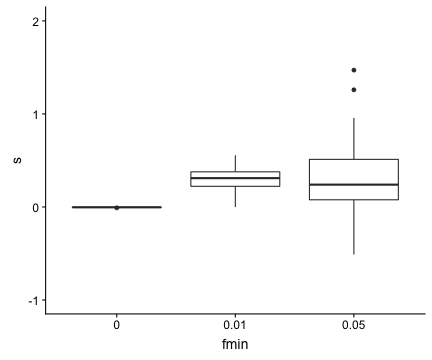

RObject{VecSxp}


In [82]:
R"""
sout %>%
mutate(fmin = paste0(fmin)) %>%
ggplot(aes(x = fmin, y = s)) +
geom_boxplot() +
ylim(c(-1, 2))
"""

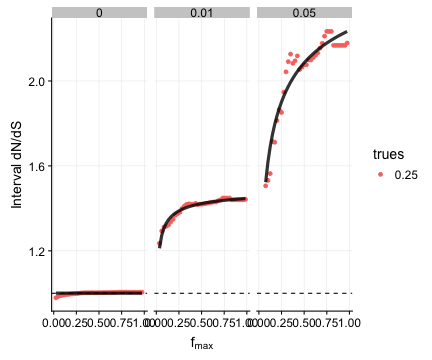

RObject{VecSxp}


In [81]:
R"""

gsim <- dnds %>%
filter(simulationset == 3) %>%
mutate(trues = paste0(trues)) %>%
ggplot2::ggplot(ggplot2::aes(x = CCF, y = dnds)) +
ggplot2::geom_point(aes(col = trues)) +
    ggplot2::geom_line(ggplot2::aes(y = dndsth),  size = 1.5, alpha = 0.8) +
    #ggplot2::geom_ribbon(ggplot2::aes(ymin = dndsthmin, ymax = dndsthmax, fill = trues), alpha = 0.2) +
    ggplot2::ylab("Interval \n dN/dS") + ggplot2::xlab(expression(f[max])) +
    geom_hline(yintercept = 1.0, lty = 2) +
    xlab(expression(f[max])) +
    ylab("Interval dN/dS") +
    #scale_fill_hue(l=40) +
    background_grid(major = "xy", minor = "none") +
    facet_wrap(~fmin)
"""